# Celda 1 — Importación y configuración

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, confusion_matrix, classification_report
)

# Estilo gráfico
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["figure.dpi"] = 120

# Reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Rutas
ROOT = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
DATA_PATH = (ROOT / "../data/raw/structured_endometriosis_data.csv").resolve()
FIG_PATH = (ROOT / "../reports/figures").resolve()
METRICS_PATH = (ROOT / "../reports/metrics").resolve()
FIG_PATH.mkdir(parents=True, exist_ok=True)
METRICS_PATH.mkdir(parents=True, exist_ok=True)

# Celda 2 — Carga de dataset

In [40]:
df = pd.read_csv(DATA_PATH)
print("Dataset cargado correctamente.")
print("Forma:", df.shape)
display(df.head())

TARGET = "Diagnosis"   # 0 = No, 1 = Sí
assert TARGET in df.columns, "No se encontró la columna objetivo."

print("\nDistribución de Diagnosis (%):")
display((df[TARGET].value_counts(normalize=True) * 100).round(2))

Dataset cargado correctamente.
Forma: (10000, 7)


,Age,Menstrual_Irregularity,Chronic_Pain_Level,Hormone_Level_Abnormality,Infertility,BMI,Diagnosis
0,24,1,8.361531,0,0,19.451314,0
1,37,1,4.995508,0,0,22.388436,0
2,46,1,3.363996,1,0,21.320443,0
3,32,1,5.246037,0,0,20.177715,1
4,28,1,3.898932,1,0,23.538103,1



Distribución de Diagnosis (%):


Diagnosis
0    59.21
1    40.79
Name: proportion, dtype: float64

# Celda 3 — Preparación

In [41]:
data = df.copy()

# Separar numéricas y categóricas
num_cols = data.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = data.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

if TARGET in num_cols: num_cols.remove(TARGET)
if TARGET in cat_cols: cat_cols.remove(TARGET)

# Imputación simple
for c in num_cols:
    data[c] = data[c].fillna(data[c].median())
for c in cat_cols:
    moda = data[c].mode(dropna=True)
    data[c] = data[c].fillna(moda.iloc[0] if len(moda) else "Desconocido")

# One-hot encoding
X = pd.get_dummies(data.drop(columns=[TARGET]), drop_first=True)
y = data[TARGET].astype(int)

print("X:", X.shape, "| y:", y.shape)

X: (10000, 6) | y: (10000,)


# Celda 4 — Train/Test split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)
print("Distribución en train:", y_train.value_counts(normalize=True).round(3).to_dict())
print("Distribución en test:", y_test.value_counts(normalize=True).round(3).to_dict())

Tamaño del conjunto de entrenamiento: (7000, 6)
Tamaño del conjunto de prueba: (3000, 6)
Distribución en train: {0: 0.592, 1: 0.408}
Distribución en test: {0: 0.592, 1: 0.408}


# Celda 5 — Funciones para métricas y gráficos

In [43]:
def mostrar_metricas(y_true, y_pred, y_score):
    """Calcula y muestra métricas básicas."""
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    roc  = roc_auc_score(y_true, y_score)
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1-score:  {f1:.3f}")
    print(f"ROC-AUC:   {roc:.3f}")

def mostrar_confusion(y_true, y_pred, titulo):
    """Grafica la matriz de confusión."""
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Endo (0)", "Sí Endo (1)"],
                yticklabels=["No Endo (0)", "Sí Endo (1)"])
    plt.title(titulo)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

def mostrar_roc(y_true, y_score, titulo):
    """Grafica la curva ROC."""
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, label="ROC")
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.xlabel("Tasa de falsos positivos")
    plt.ylabel("Tasa de verdaderos positivos")
    plt.title(titulo)
    plt.legend()
    plt.show()


# Celda 6 — Regresión Logística

=== REGRESIÓN LOGÍSTICA ===
Accuracy:  0.625
Precision: 0.562
Recall:    0.364
F1-score:  0.441
ROC-AUC:   0.654

Reporte de clasificación:
              precision    recall  f1-score   support

      No (0)       0.65      0.80      0.72      1776
      Sí (1)       0.56      0.36      0.44      1224

    accuracy                           0.62      3000
   macro avg       0.60      0.58      0.58      3000
weighted avg       0.61      0.62      0.60      3000



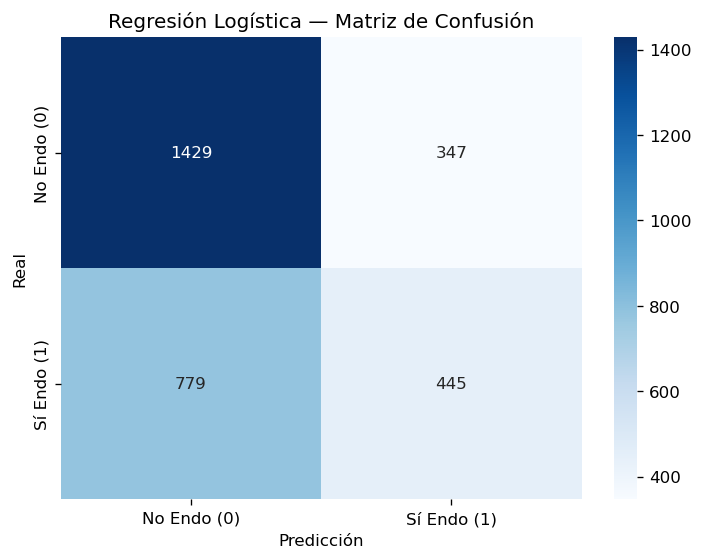

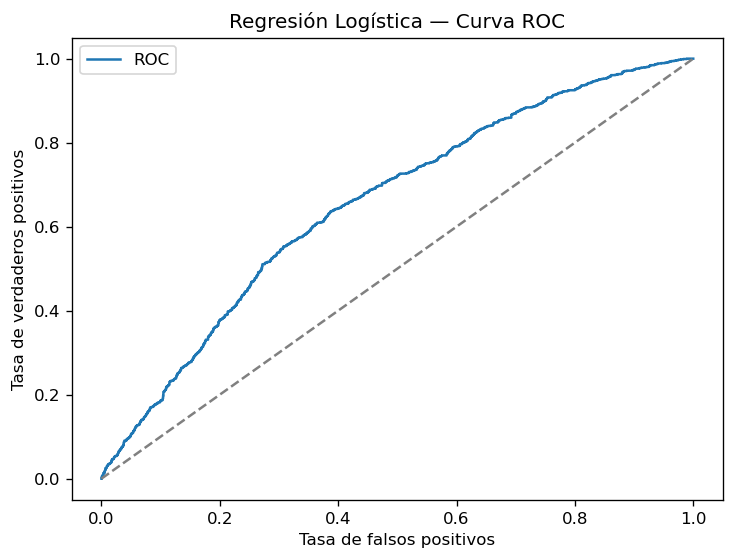

In [44]:
print("=== REGRESIÓN LOGÍSTICA ===")

# Escalar solo las variables
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
log_reg.fit(X_train_sc, y_train)

# Predicciones
y_pred_lr  = log_reg.predict(X_test_sc)
y_score_lr = log_reg.predict_proba(X_test_sc)[:,1]

# Resultados
mostrar_metricas(y_test, y_pred_lr, y_score_lr)
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_lr, target_names=["No (0)", "Sí (1)"]))

# Gráficos
mostrar_confusion(y_test, y_pred_lr, "Regresión Logística — Matriz de Confusión")
mostrar_roc(y_test, y_score_lr, "Regresión Logística — Curva ROC")


# Celda 7 — Árbol de Decisión

=== ÁRBOL DE DECISIÓN ===
Accuracy:  0.539
Precision: 0.438
Recall:    0.462
F1-score:  0.450
ROC-AUC:   0.527

Reporte de clasificación:
              precision    recall  f1-score   support

      No (0)       0.61      0.59      0.60      1776
      Sí (1)       0.44      0.46      0.45      1224

    accuracy                           0.54      3000
   macro avg       0.53      0.53      0.53      3000
weighted avg       0.54      0.54      0.54      3000



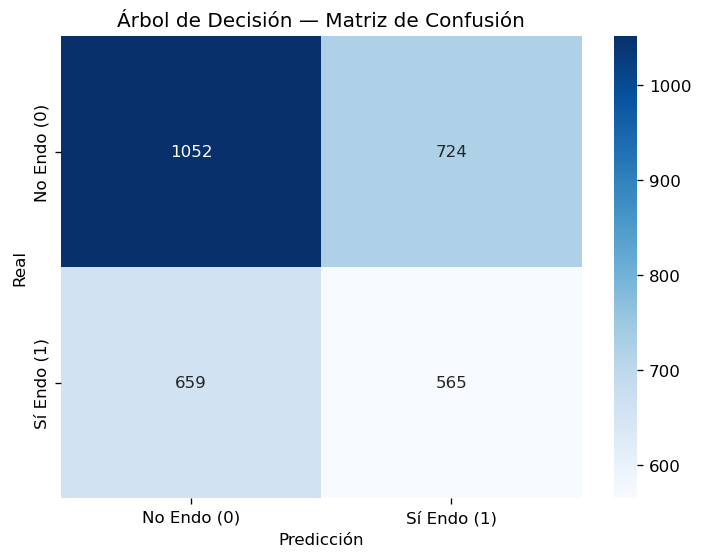

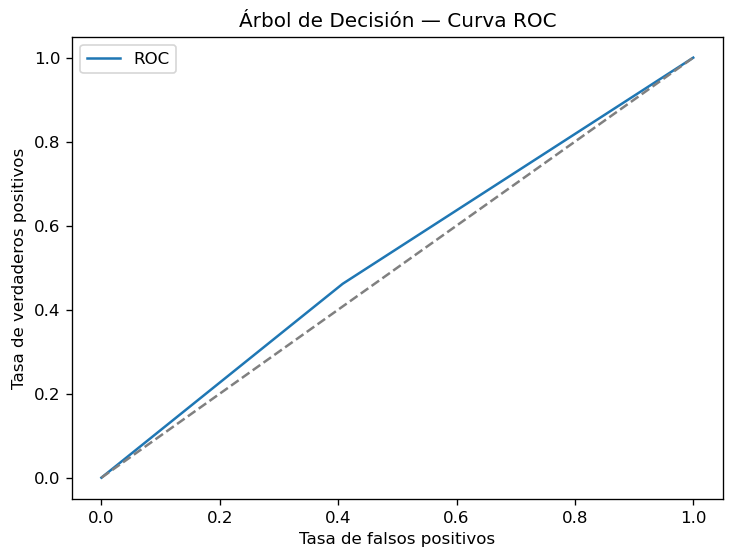

In [45]:
print("=== ÁRBOL DE DECISIÓN ===")

tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree.fit(X_train, y_train)

y_pred_dt  = tree.predict(X_test)
y_score_dt = tree.predict_proba(X_test)[:,1]

mostrar_metricas(y_test, y_pred_dt, y_score_dt)
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_dt, target_names=["No (0)", "Sí (1)"]))

mostrar_confusion(y_test, y_pred_dt, "Árbol de Decisión — Matriz de Confusión")
mostrar_roc(y_test, y_score_dt, "Árbol de Decisión — Curva ROC")


# Celda 8 — Comparativa de modelos

In [46]:
resultados = pd.DataFrame([
    {
        "Modelo": "Regresión Logística",
        "Accuracy":  accuracy_score(y_test, y_pred_lr),
        "Precision": precision_score(y_test, y_pred_lr, zero_division=0),
        "Recall":    recall_score(y_test, y_pred_lr, zero_division=0),
        "F1-score":  f1_score(y_test, y_pred_lr, zero_division=0),
        "ROC-AUC":   roc_auc_score(y_test, y_score_lr)
    },
    {
        "Modelo": "Árbol de Decisión",
        "Accuracy":  accuracy_score(y_test, y_pred_dt),
        "Precision": precision_score(y_test, y_pred_dt, zero_division=0),
        "Recall":    recall_score(y_test, y_pred_dt, zero_division=0),
        "F1-score":  f1_score(y_test, y_pred_dt, zero_division=0),
        "ROC-AUC":   roc_auc_score(y_test, y_score_dt)
    }
])

display(resultados.round(3))


,Modelo,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Regresión Logística,0.625,0.562,0.364,0.441,0.654
1,Árbol de Decisión,0.539,0.438,0.462,0.450,0.527
